In [ ]:
# ============================================
# Імпорти та завантаження датасету
# ============================================
!pip install kagglehub

import kagglehub
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Dropout,
                                     Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG19

# Завантаження датасету з Kaggle
path_to_dataset = kagglehub.dataset_download("harieh/ocr-dataset")
print("Path to dataset files:", path_to_dataset)


Path to dataset files: /root/.cache/kagglehub/datasets/harieh/ocr-dataset/versions/1


In [ ]:
# ============================================
# Глобальні параметри та допоміжні функції
# ============================================
IMG_SIZE = (32, 32, 3)  # розмір зображень
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

def directory_to_df(path: str):
    """
    Збирає шляхи до зображень і відповідні мітки (label) у DataFrame.
    Враховуємо лише папки, які закінчуються на '_L' (малі літери).
    """
    data_list = []
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        if not os.path.isdir(folder_path):
            continue
        if not folder_name.endswith('_L'):
            continue
        label = folder_name.split('_')[0]
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            data_list.append([img_path, label])
    df = pd.DataFrame(data_list, columns=['image', 'label'])
    print("Знайдено зображень:", len(df))
    print("Класи (папки):", df['label'].unique())
    return df

def read_image(path):
    """Завантажує зображення у форматі RGB."""
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_callbacks(model_name):
    """
    Колбеки:
    - ReduceLROnPlateau (зменшення LR при застої)
    - ModelCheckpoint (збереження найкращої моделі)
    """
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    chkp = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_loss', save_best_only=True, verbose=1)
    return [rlrop, chkp]

def show_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(class_names))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(class_names),
                yticklabels=sorted(class_names))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def show_typical_errors(test_gen, y_true, y_pred, mapping_inverse, num_samples=5):
    """Відобразити кілька прикладів, де модель помилилась."""
    misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    print(f"Приклади типових помилок (всього помилок: {len(misclassified_indices)}):")
    for idx in misclassified_indices[:num_samples]:
        img_path = test_gen.filenames[idx]
        full_path = os.path.join(test_gen.directory, img_path)
        img = read_image(full_path)
        plt.imshow(img)
        plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
        plt.axis('off')
        plt.show()


In [ ]:
# ============================================
# Підготовка DataFrame та генератори
# ============================================
main_path = os.path.join(path_to_dataset, "dataset")
df = directory_to_df(main_path)
print(df.head())

print("Розподіл по літерах:")
print(df['label'].value_counts())

# Спліт 70/30
X_train, X_test, y_train, y_test = train_test_split(
    df['image'], df['label'], test_size=0.3, random_state=42
)
train_df = pd.DataFrame({'image': X_train, 'label': y_train})
test_df  = pd.DataFrame({'image': X_test,  'label': y_test})

# Із train_df виділимо 25% на валідацію
X_train2, X_val, y_train2, y_val = train_test_split(
    train_df['image'], train_df['label'], test_size=0.25, random_state=42
)
train_df = pd.DataFrame({'image': X_train2, 'label': y_train2})
val_df   = pd.DataFrame({'image': X_val,    'label': y_val})

print("Train size:", len(train_df), "| Val size:", len(val_df), "| Test size:", len(test_df))

Знайдено зображень: 85199
Класи (папки): ['a' 'd' 'e' 's' 'g' 'z' 'v' 'c' 'p' 'l' 'f' 'b' 'u' 'x' 'q' 'h' 'o' 'k'
 'm' 'n' 'w' 'y' 'r' 't' 'i' 'j']
                                               image label
0  /root/.cache/kagglehub/datasets/harieh/ocr-dat...     a
1  /root/.cache/kagglehub/datasets/harieh/ocr-dat...     a
2  /root/.cache/kagglehub/datasets/harieh/ocr-dat...     a
3  /root/.cache/kagglehub/datasets/harieh/ocr-dat...     a
4  /root/.cache/kagglehub/datasets/harieh/ocr-dat...     a
Розподіл по літерах:
label
e    3284
r    3284
m    3281
n    3281
a    3281
q    3279
u    3278
d    3277
i    3277
s    3276
t    3276
y    3276
k    3276
x    3276
l    3276
g    3275
p    3275
z    3275
w    3275
o    3275
f    3275
h    3275
v    3274
c    3274
b    3274
j    3274
Name: count, dtype: int64
Train size: 44729 | Val size: 14910 | Test size: 25560


In [ ]:
# Генератори зображень
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='image', y_col='label',
    target_size=(IMG_SIZE[0], IMG_SIZE[1]), class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='image', y_col='label',
    target_size=(IMG_SIZE[0], IMG_SIZE[1]), class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='image', y_col='label',
    target_size=(IMG_SIZE[0], IMG_SIZE[1]), class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

class_indices = train_gen.class_indices
mapping_inverse = dict((v,k) for k,v in class_indices.items())
num_classes = len(class_indices)
print("Кількість класів:", num_classes)
print("mapping_inverse:", mapping_inverse)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.
Кількість класів: 26
mapping_inverse: {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


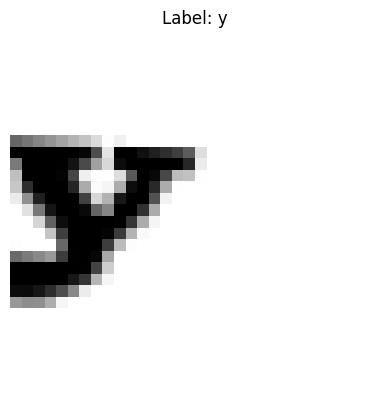

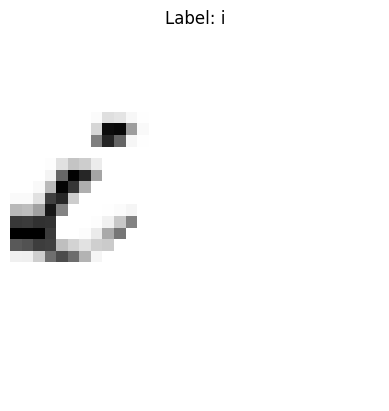

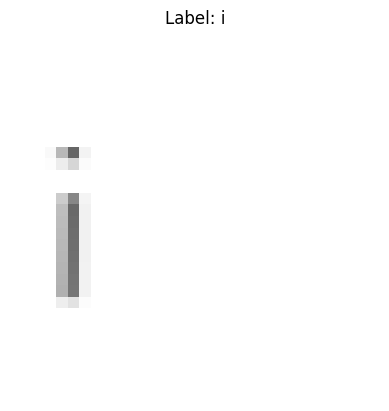

In [ ]:
# Приклад візуалізації
batch = next(iter(train_gen))
images, labels = batch
for i in range(3):
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    class_name = mapping_inverse[label_idx]
    plt.title(f"Label: {class_name}")
    plt.axis('off')
    plt.show()


=== Навчання CNN ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (32, 32, 32, 3)             │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 30, 30, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 10, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 8, 8, 256)             │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 8, 8, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 4, 4, 256)             │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 2, 2, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 2, 2, 512)             │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 2, 2, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 2, 2, 1024)            │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 1, 1, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 1024)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 1024)                  │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 26)                    │          26,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.44742, saving model to CNN_best.h5


1398/1398 - 59s - 42ms/step - accuracy: 0.5865 - loss: 1.3747 - val_accuracy: 0.8772 - val_loss: 0.4474 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_loss improved from 0.44742 to 0.32551, saving model to CNN_best.h5


1398/1398 - 82s - 59ms/step - accuracy: 0.8537 - loss: 0.4994 - val_accuracy: 0.9086 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_loss improved from 0.32551 to 0.28261, saving model to CNN_best.h5


1398/1398 - 47s - 34ms/step - accuracy: 0.8879 - loss: 0.3826 - val_accuracy: 0.9205 - val_loss: 0.2826 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_loss improved from 0.28261 to 0.23504, saving model to CNN_best.h5


1398/1398 - 47s - 33ms/step - accuracy: 0.9048 - loss: 0.3201 - val_accuracy: 0.9307 - val_loss: 0.2350 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_loss improved from 0.23504 to 0.20616, saving model to CNN_best.h5


1398/1398 - 46s - 33ms/step - accuracy: 0.9146 - loss: 0.2834 - val_accuracy: 0.9388 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_loss did not improve from 0.20616
1398/1398 - 45s - 32ms/step - accuracy: 0.9241 - loss: 0.2554 - val_accuracy: 0.9351 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_loss improved from 0.20616 to 0.17376, saving model to CNN_best.h5


1398/1398 - 44s - 32ms/step - accuracy: 0.9270 - loss: 0.2374 - val_accuracy: 0.9494 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_loss did not improve from 0.17376
1398/1398 - 45s - 32ms/step - accuracy: 0.9328 - loss: 0.2211 - val_accuracy: 0.9468 - val_loss: 0.1800 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_loss did not improve from 0.17376
1398/1398 - 45s - 32ms/step - accuracy: 0.9359 - loss: 0.2090 - val_accuracy: 0.9445 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_loss improved from 0.17376 to 0.16436, saving model to CNN_best.h5


1398/1398 - 83s - 59ms/step - accuracy: 0.9395 - loss: 0.1986 - val_accuracy: 0.9498 - val_loss: 0.1644 - learning_rate: 1.0000e-04


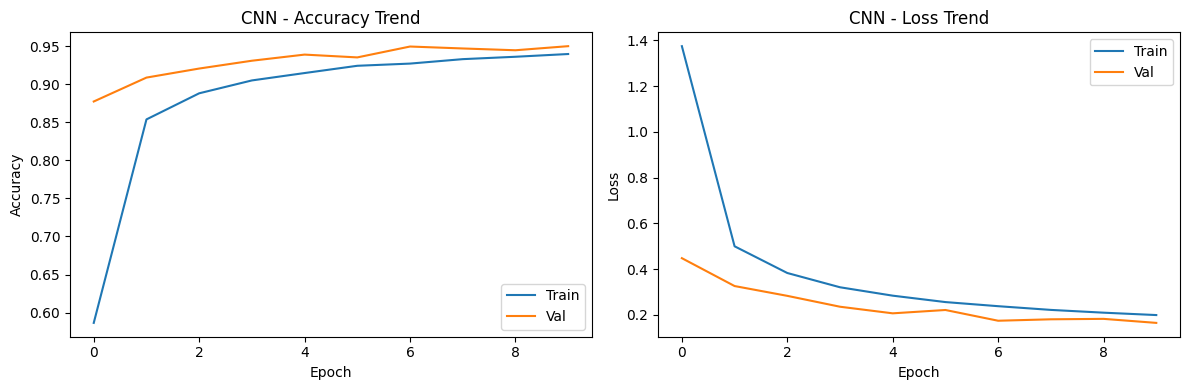

In [ ]:
# ============================================
# Навчання CNN + Аналіз помилок
# ============================================
print("\n=== Навчання CNN ===")
CNN = Sequential()
CNN.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN.add(Conv2D(128, (3,3), activation='relu'))
CNN.add(MaxPool2D((3,3)))
CNN.add(Conv2D(256, (3,3), activation='relu'))
CNN.add(Dropout(0.2))
CNN.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN.add(MaxPool2D((2,2)))
CNN.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN.add(Dropout(0.2))
CNN.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN.add(MaxPool2D((2,2)))
CNN.add(Flatten())
CNN.add(Dense(1024, activation='selu'))
CNN.add(Dense(num_classes, activation='softmax'))

CNN.compile(optimizer=Adam(learning_rate=LR),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

CNN.summary()

callbacks_cnn = get_callbacks("CNN")
history_cnn = CNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks_cnn,
    verbose=2
)

# Відображаємо Accuracy/Loss Trend
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train')
plt.plot(history_cnn.history['val_accuracy'], label='Val')
plt.title("CNN - Accuracy Trend")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train')
plt.plot(history_cnn.history['val_loss'], label='Val')
plt.title("CNN - Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


=== CNN Classification Report ===
              precision    recall  f1-score   support

           a       0.98      0.92      0.95      1007
           b       0.98      0.94      0.96      1032
           c       0.97      0.95      0.96       963
           d       0.95      0.98      0.96       952
           e       0.98      0.92      0.95       977
           f       0.92      0.98      0.95      1051
           g       0.94      0.94      0.94       990
           h       0.93      0.97      0.95       956
           i       0.98      0.91      0.94      1022
           j       0.97      0.97      0.97       984
           k       0.97      0.97      0.97       981
           l       0.91      0.96      0.94       992
           m       0.93      0.98      0.95       960
           n       0.90      0.95      0.93      1013
           o       0.96      0.95      0.96      1005
           p       0.99      0.97      0.98       970
           q       0.96      0.97      0.96   

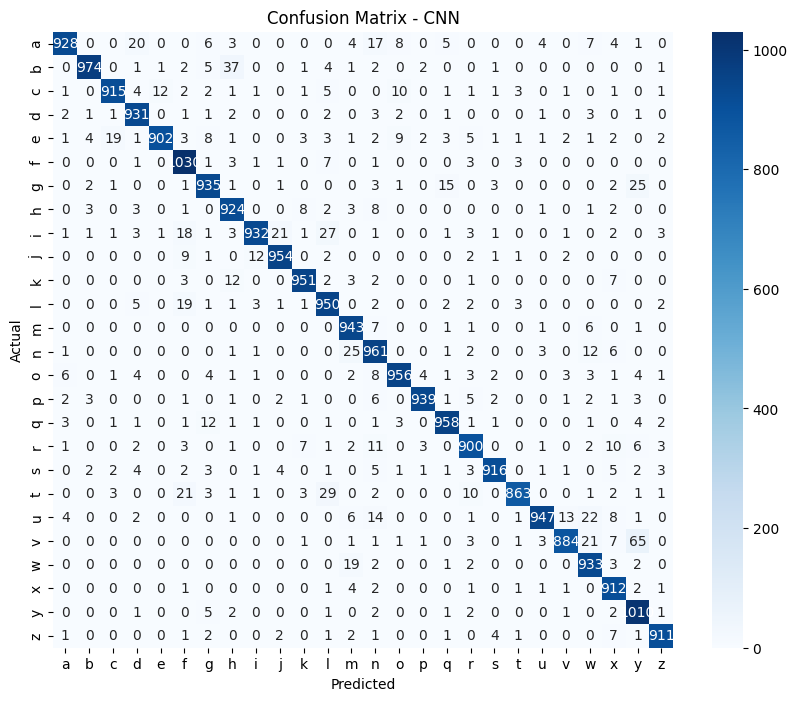

Приклади типових помилок (всього помилок: 1201):


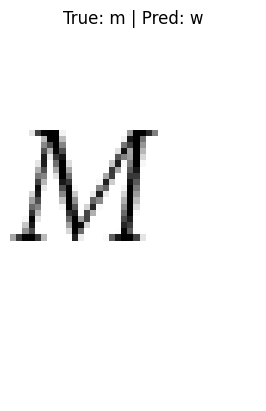

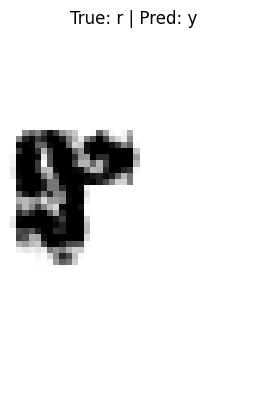

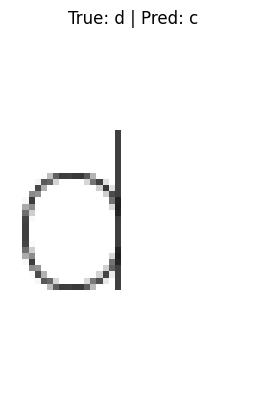

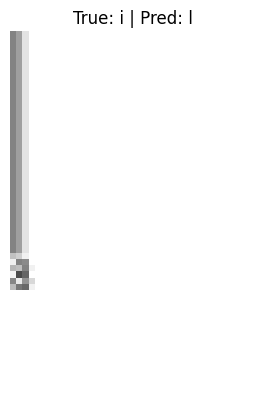

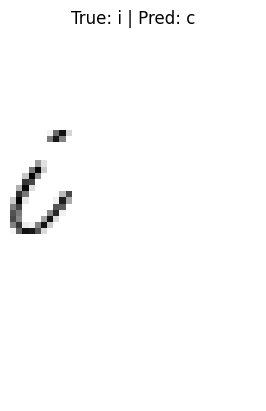

In [ ]:
# Оцінка на тесті
best_cnn = tf.keras.models.load_model("CNN_best.h5")
pred_probs = best_cnn.predict(test_gen, verbose=0)
y_pred = np.argmax(pred_probs, axis=1)
y_test_true = test_gen.classes

y_pred_labels = [mapping_inverse[i] for i in y_pred]
y_test_labels = [mapping_inverse[i] for i in y_test_true]

print("\n=== CNN Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

show_confusion_matrix(y_test_labels, y_pred_labels,
                      class_names=class_indices.keys(),
                      title="Confusion Matrix - CNN")

show_typical_errors(test_gen, y_test_labels, y_pred_labels,
                    mapping_inverse, num_samples=5)

In [ ]:
# ДОДАТКОВИЙ АНАЛІЗ ПОМИЛОК
misclassified_pairs = {}
for true_l, pred_l in zip(y_test_labels, y_pred_labels):
    if true_l != pred_l:
        pair = (true_l, pred_l)
        misclassified_pairs[pair] = misclassified_pairs.get(pair, 0) + 1

sorted_pairs = sorted(misclassified_pairs.items(), key=lambda x: x[1], reverse=True)
print("\n=== Найчастіші помилки (true -> pred) [CNN] ===")
for (t, p), freq in sorted_pairs[:10]:
    print(f"{t} → {p} : {freq} раз(ів)")

from collections import Counter
counts_true = Counter(y_test_labels)
counts_mis  = Counter([tl for tl, pl in zip(y_test_labels, y_pred_labels) if tl != pl])

print("\n=== Помилки по кожній літері (error ratio) [CNN] ===")
letters_sorted = sorted(counts_true.keys())
for letter in letters_sorted:
    total = counts_true[letter]
    mis   = counts_mis[letter]
    ratio = mis / total if total > 0 else 0
    print(f"Літера '{letter}': {mis} помилок із {total} (частка {ratio:.2f})")


=== Найчастіші помилки (true -> pred) [CNN] ===
v → y : 65 раз(ів)
b → h : 37 раз(ів)
t → l : 29 раз(ів)
i → l : 27 раз(ів)
g → y : 25 раз(ів)
n → m : 25 раз(ів)
u → w : 22 раз(ів)
t → f : 21 раз(ів)
v → w : 21 раз(ів)
i → j : 21 раз(ів)

=== Помилки по кожній літері (error ratio) [CNN] ===
Літера 'a': 79 помилок із 1007 (частка 0.08)
Літера 'b': 58 помилок із 1032 (частка 0.06)
Літера 'c': 48 помилок із 963 (частка 0.05)
Літера 'd': 21 помилок із 952 (частка 0.02)
Літера 'e': 75 помилок із 977 (частка 0.08)
Літера 'f': 21 помилок із 1051 (частка 0.02)
Літера 'g': 55 помилок із 990 (частка 0.06)
Літера 'h': 32 помилок із 956 (частка 0.03)
Літера 'i': 90 помилок із 1022 (частка 0.09)
Літера 'j': 30 помилок із 984 (частка 0.03)
Літера 'k': 30 помилок із 981 (частка 0.03)
Літера 'l': 42 помилок із 992 (частка 0.04)
Літера 'm': 17 помилок із 960 (частка 0.02)
Літера 'n': 52 помилок із 1013 (частка 0.05)
Літера 'o': 49 помилок із 1005 (частка 0.05)
Літера 'p': 31 помилок із 970 (частка 0.0


=== Навчання VGG19 ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │          13,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,087,834 (80.44 MB)

 Trainable params: 21,087,834 (80.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.28956, saving model to VGG19_best.h5


1398/1398 - 98s - 70ms/step - accuracy: 0.8511 - loss: 0.5304 - val_accuracy: 0.9176 - val_loss: 0.2896 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss improved from 0.28956 to 0.22198, saving model to VGG19_best.h5


1398/1398 - 86s - 62ms/step - accuracy: 0.9222 - loss: 0.2636 - val_accuracy: 0.9329 - val_loss: 0.2220 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 3: val_loss improved from 0.22198 to 0.19260, saving model to VGG19_best.h5


1398/1398 - 83s - 60ms/step - accuracy: 0.9338 - loss: 0.2199 - val_accuracy: 0.9411 - val_loss: 0.1926 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: val_loss improved from 0.19260 to 0.15887, saving model to VGG19_best.h5


1398/1398 - 82s - 58ms/step - accuracy: 0.9401 - loss: 0.1948 - val_accuracy: 0.9537 - val_loss: 0.1589 - learning_rate: 1.0000e-05
Epoch 5/10

Epoch 5: val_loss improved from 0.15887 to 0.14367, saving model to VGG19_best.h5


1398/1398 - 83s - 59ms/step - accuracy: 0.9462 - loss: 0.1757 - val_accuracy: 0.9579 - val_loss: 0.1437 - learning_rate: 1.0000e-05
Epoch 6/10

Epoch 6: val_loss did not improve from 0.14367
1398/1398 - 85s - 61ms/step - accuracy: 0.9499 - loss: 0.1615 - val_accuracy: 0.9555 - val_loss: 0.1500 - learning_rate: 1.0000e-05
Epoch 7/10

Epoch 7: val_loss improved from 0.14367 to 0.12658, saving model to VGG19_best.h5


1398/1398 - 83s - 59ms/step - accuracy: 0.9532 - loss: 0.1502 - val_accuracy: 0.9624 - val_loss: 0.1266 - learning_rate: 1.0000e-05
Epoch 8/10

Epoch 8: val_loss did not improve from 0.12658
1398/1398 - 85s - 61ms/step - accuracy: 0.9552 - loss: 0.1439 - val_accuracy: 0.9605 - val_loss: 0.1322 - learning_rate: 1.0000e-05
Epoch 9/10

Epoch 9: val_loss did not improve from 0.12658
1398/1398 - 82s - 59ms/step - accuracy: 0.9582 - loss: 0.1321 - val_accuracy: 0.9596 - val_loss: 0.1364 - learning_rate: 1.0000e-05
Epoch 10/10

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 10: val_loss did not improve from 0.12658
1398/1398 - 81s - 58ms/step - accuracy: 0.9601 - loss: 0.1259 - val_accuracy: 0.9608 - val_loss: 0.1382 - learning_rate: 1.0000e-05


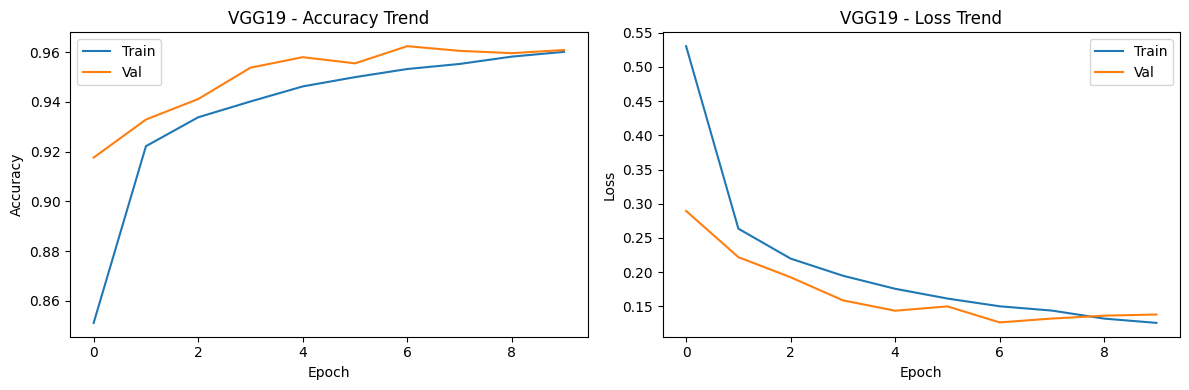

In [ ]:
# ============================================
# Навчання VGG19 + Аналіз помилок
# ============================================
print("\n=== Навчання VGG19 ===")
vgg_base = VGG19(include_top=False, input_shape=IMG_SIZE)
VGG = Sequential()
VGG.add(vgg_base)
VGG.add(Flatten())
VGG.add(Dense(1024, activation='selu'))
VGG.add(Dense(512, activation='selu'))
VGG.add(Dense(num_classes, activation='softmax'))

VGG.compile(optimizer=Adam(learning_rate=1e-5, epsilon=1e-6),
            loss="categorical_crossentropy",
            metrics=['accuracy'])

VGG.summary()

callbacks_vgg = get_callbacks("VGG19")
history_vgg = VGG.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks_vgg,
    verbose=2
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Train')
plt.plot(history_vgg.history['val_accuracy'], label='Val')
plt.title("VGG19 - Accuracy Trend")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Train')
plt.plot(history_vgg.history['val_loss'], label='Val')
plt.title("VGG19 - Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


=== VGG19 Classification Report ===
              precision    recall  f1-score   support

           a       0.96      0.97      0.96      1007
           b       0.96      0.98      0.97      1032
           c       0.92      0.97      0.95       963
           d       0.97      0.98      0.97       952
           e       0.95      0.95      0.95       977
           f       0.97      0.97      0.97      1051
           g       0.94      0.95      0.95       990
           h       0.98      0.95      0.97       956
           i       0.99      0.94      0.96      1022
           j       0.96      0.98      0.97       984
           k       0.99      0.96      0.97       981
           l       0.90      0.98      0.94       992
           m       0.98      0.98      0.98       960
           n       0.96      0.96      0.96      1013
           o       0.98      0.95      0.96      1005
           p       0.97      0.97      0.97       970
           q       0.98      0.95      0.97 

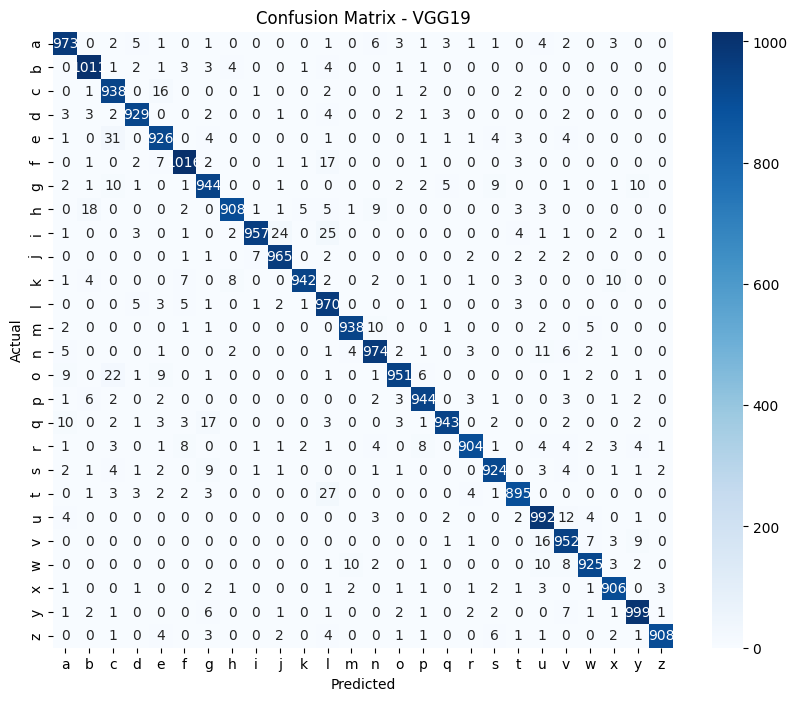

Приклади типових помилок (всього помилок: 926):


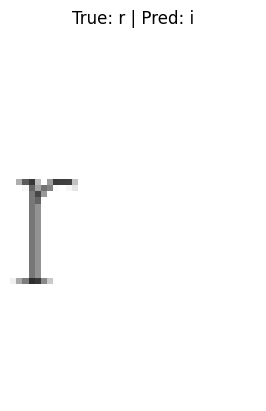

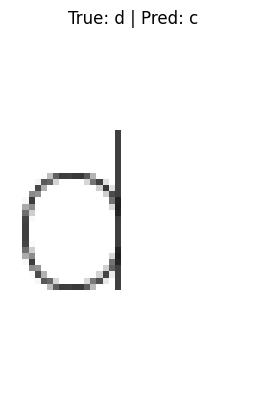

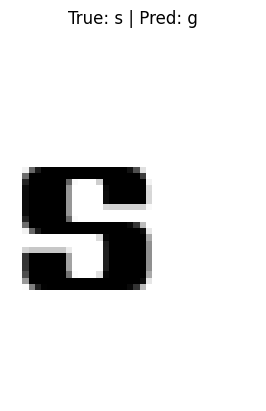

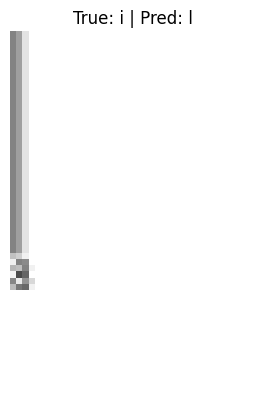

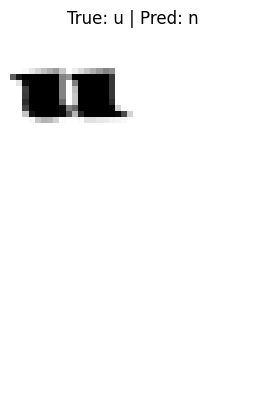

In [ ]:
# Оцінка на тесті
best_vgg = tf.keras.models.load_model("VGG19_best.h5")
pred_probs_vgg = best_vgg.predict(test_gen, verbose=0)
y_pred_vgg = np.argmax(pred_probs_vgg, axis=1)
y_pred_labels_vgg = [mapping_inverse[i] for i in y_pred_vgg]

print("\n=== VGG19 Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels_vgg))

show_confusion_matrix(y_test_labels, y_pred_labels_vgg,
                      class_names=class_indices.keys(),
                      title="Confusion Matrix - VGG19")

show_typical_errors(test_gen, y_test_labels, y_pred_labels_vgg,
                    mapping_inverse, num_samples=5)

In [ ]:
# ДОДАТКОВИЙ АНАЛІЗ ПОМИЛОК
misclassified_pairs_vgg = {}
for true_l, pred_l in zip(y_test_labels, y_pred_labels_vgg):
    if true_l != pred_l:
        pair = (true_l, pred_l)
        misclassified_pairs_vgg[pair] = misclassified_pairs_vgg.get(pair, 0) + 1

sorted_pairs_vgg = sorted(misclassified_pairs_vgg.items(), key=lambda x: x[1], reverse=True)
print("\n=== Найчастіші помилки (true -> pred) [VGG19] ===")
for (t, p), freq in sorted_pairs_vgg[:10]:
    print(f"{t} → {p} : {freq} раз(ів)")

counts_true_vgg = Counter(y_test_labels)
counts_mis_vgg  = Counter([tl for tl, pl in zip(y_test_labels, y_pred_labels_vgg) if tl != pl])

print("\n=== Помилки по кожній літері (error ratio) [VGG19] ===")
letters_sorted_vgg = sorted(counts_true_vgg.keys())
for letter in letters_sorted_vgg:
    total = counts_true_vgg[letter]
    mis   = counts_mis_vgg[letter]
    ratio = mis / total if total > 0 else 0
    print(f"Літера '{letter}': {mis} помилок із {total} (частка {ratio:.2f})")

print("\nЗавершено! Навчили CNN і VGG19, побудували Confusion Matrices, Accuracy Trends, ілюстрували помилки, "
      "а також проаналізували найчастіші пари помилок та error ratio по кожній літері.")


=== Найчастіші помилки (true -> pred) [VGG19] ===
e → c : 31 раз(ів)
t → l : 27 раз(ів)
i → l : 25 раз(ів)
i → j : 24 раз(ів)
o → c : 22 раз(ів)
h → b : 18 раз(ів)
f → l : 17 раз(ів)
q → g : 17 раз(ів)
c → e : 16 раз(ів)
v → u : 16 раз(ів)

=== Помилки по кожній літері (error ratio) [VGG19] ===
Літера 'a': 34 помилок із 1007 (частка 0.03)
Літера 'b': 21 помилок із 1032 (частка 0.02)
Літера 'c': 25 помилок із 963 (частка 0.03)
Літера 'd': 23 помилок із 952 (частка 0.02)
Літера 'e': 51 помилок із 977 (частка 0.05)
Літера 'f': 35 помилок із 1051 (частка 0.03)
Літера 'g': 46 помилок із 990 (частка 0.05)
Літера 'h': 48 помилок із 956 (частка 0.05)
Літера 'i': 65 помилок із 1022 (частка 0.06)
Літера 'j': 19 помилок із 984 (частка 0.02)
Літера 'k': 39 помилок із 981 (частка 0.04)
Літера 'l': 22 помилок із 992 (частка 0.02)
Літера 'm': 22 помилок із 960 (частка 0.02)
Літера 'n': 39 помилок із 1013 (частка 0.04)
Літера 'o': 54 помилок із 1005 (частка 0.05)
Літера 'p': 26 помилок із 970 (частка